In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Merging and Cleaning Outputs for Human Evaluation

This section focuses on merging and cleaning the outputs from the T5-Small, T5-LoRA, and T5-LoRA with Beam Search models. The process ensures the outputs are properly prepared and aligned with the input vague goals, enabling standalone evaluation of each model. Each model's outputs were assessed independently based on faithfulness, SMART adherence, and coherence, rather than through direct comparison.

For T5-Base, was not incuded in the merge, the outputs were exported to Excel, and the same sample of 45 vague goals were manually matched using Excel to ensure consistency with the goals evaluated for the other models. Using the same sample ensured the chain of evidence remained intact, enabling the scores for faithfulness, SMART adherence, and coherence to be averaged across models. This adjustment adhered to the same standalone evaluation methodology applied to the other models.


In [ ]:
import pandas as pd

# File paths for evaluation results
#t5_untuned_file = "/content/drive/My Drive/model_evaluation_T5_Base_new.csv"
t5_Baseline_file ="/content/drive/My Drive/model_evaluation_T5_results_new.csv"
t5_LoRA_file = "/content/drive/My Drive/model_evaluation_T5_LoRA_results_new.csv"
t5_Beam_file = "/content/drive/My Drive/model_evaluation_T5_Beam_results_new.csv"


# Load DataFrames
#t5_untuned_df = pd.read_csv(t5_untuned_file)
t5_Baseline_df = pd.read_csv(t5_Baseline_file)
t5_LoRA_df = pd.read_csv(t5_LoRA_file)
t5_Beam_df = pd.read_csv(t5_Beam_file)


def clean_input_column(df):

    #Cleans the 'Input' column by removing unwanted prefixes, including context and input markers.
    #Handles varying prefixes like 'Context: <context_type> Input:'.

    # Use a regex to remove varying context and input prefixes
    df["Input"] = (
        df["Input"]
        #.str.replace(r"^Context: [^:]: ", "", regex=True)  # Remove 'Context: <context_type> Input:'
        .str.replace("vague goal to SMART goal: ", "", regex=False)  # Remove vague goal prefix
        .str.strip()  # Remove leading/trailing whitespace
    )
    return df




# Apply the cleaning function to all DataFrames

t5_Baseline_df = clean_input_column(t5_Baseline_df)
t5_LoRA_df = clean_input_column(t5_LoRA_df)
t5_Beam_df = clean_input_column(t5_Beam_df)

# Preview the cleaned DataFrames


print("\nT5 Baseline DataFrame Preview:")
print(t5_Baseline_df.head(5))

print("\nT5 LoRA DataFrame Preview:")
print(t5_LoRA_df.head(5))

print("\nT5 Beam DataFrame Preview:")
print(t5_Beam_df.head(5))


# Standardize column names
#few_shot_df.rename(columns={"Output": "SMART Goal_FewShot", "Input": "Vague Goal"}, inplace=True)
t5_Baseline_df.rename(columns={"Output": "SMART Goal_T5Untuned", "Input": "Vague Goal"}, inplace=True)
t5_LoRA_df.rename(columns={"Output": "SMART Goal_T5FineTuned", "Input": "Vague Goal"}, inplace=True)
t5_Beam_df.rename(columns={"Output": "SMART Goal_T5Beam", "Input": "Vague Goal"}, inplace=True)

# Merge DataFrames on "Vague Goal" using an outer join
phase1_combined = t5_Baseline_df[["Vague Goal", "SMART Goal_T5Untuned"]].merge(
    t5_LoRA_df[["Vague Goal", "SMART Goal_T5FineTuned"]], on="Vague Goal", how="outer"
).merge(
    t5_Beam_df[["Vague Goal", "SMART Goal_T5Beam"]], on="Vague Goal", how="outer")

# Save combined file
phase1_combined_path = "/content/drive/My Drive/phase1_combined.csv"
phase1_combined.to_csv(phase1_combined_path, index=False)
print(f"Phase 1 combined file saved to {phase1_combined_path}")

print(phase1_combined.shape)  # Should be (452, 5)
print(phase1_combined.isnull().sum())
print(phase1_combined.head())
















T5 Baseline DataFrame Preview:
                   Model                                              Input  \
0  Default T5 Evaluation  i’m looking to explore ways to bounce back and...   
1  Default T5 Evaluation  i’m looking to take some time to reflect on ho...   
2  Default T5 Evaluation  i’m thinking it might be worthwhile to explore...   
3  Default T5 Evaluation  ive been thinking it might be nice to connect ...   
4  Default T5 Evaluation  i’m looking to explore ways to bring more vari...   

                                           Reference  \
0  to navigate the challenges of my work environm...   
1  by the end of the next quarter, i will dedicat...   
2  by the end of the next quarter, i will enhance...   
3  in the spirit of fostering stronger connection...   
4  by the end of the next quarter, i will impleme...   

                                              Output  BERTScore  Perplexity  \
0  by the end of the next quarter, i will enhance...   0.683064    1.411778  

Sampling Outputs for Human Evaluation

In this section, a fixed sample of 45 vague goals (10% of the validation dataset) and their corresponding generated SMART goals are selected programmatically from the merged outputs. The sampling ensures reproducibility and fairness, providing a shared basis for assessing the outputs from T5-Small, T5-LoRA, and T5-LoRA with Beam Search. The selected sample is exported to an external file for standalone evaluation against SMART criteria by human evaluators.



In [ ]:
 #Sampling function
def sample_and_save(dataframe, sample_size, output_path):
    sampled_df = dataframe.sample(n=sample_size, random_state=42)  # Fixed random state for consistency
    sampled_df.to_csv(output_path, index=False)
    print(f"Sampled file saved to {output_path}")
    return sampled_df

# Take a sample of 45 rows for Phase 1
phase1_sample_size = 45  # 10% of the validation dataset
phase1_sample_path = "/content/drive/My Drive/phase1_sampled.csv"
phase1_sample = sample_and_save(phase1_combined, phase1_sample_size, phase1_sample_path)


Sampled file saved to /content/drive/My Drive/phase1_sampled.csv


Visualisation and Metrics Analysis

This section presents eight visualisations, including tables and charts, that analyze and compare the performance of the models across automated and human evaluation metrics. The automated evaluations, conducted on the validation dataset, include metrics such as faithfulness, perplexity, and BERTScore, providing a quantitative assessment of the models' outputs. Human evaluations, conducted on a 10% sample of 45 vague goals, focus on faithfulness, SMART adherence, and coherence. These visualisations highlight the strengths and trade-offs of each model, offering insights into their performance from both technical and practical perspectives.

In [ ]:
#setting up the tables for the evaluations

import pandas as pd
import os



# File paths for all evaluation results
t5_baseline_file = "/content/drive/My Drive/model_evaluation_T5_results_new.csv"
t5_lora_file = "/content/drive/My Drive/model_evaluation_T5_LoRA_results_new.csv"
t5_beam_file = "/content/drive/My Drive/model_evaluation_T5_Beam_results_new.csv"
t5_untuned_file = "/content/drive/My Drive/model_evaluation_T5_Base_new.csv"  # New file to include

# Load the data
baseline_data = pd.read_csv(t5_baseline_file)
lora_data = pd.read_csv(t5_lora_file)
beam_data = pd.read_csv(t5_beam_file)
untuned_data = pd.read_csv(t5_untuned_file)  # Load new file

# Function to calculate averages
def calculate_averages(data, model_name):
    averages = {
        "Model": model_name,
        "Faithfulness": data["Faithfulness"].mean(),
        "BERTScore": data["BERTScore"].mean(),
        "Perplexity": data["Perplexity"].mean()
    }
    return averages

# Process the models
baseline_avg = calculate_averages(baseline_data, "T5 Base")
lora_avg = calculate_averages(lora_data, "T5 LoRA")
beam_avg = calculate_averages(beam_data, "T5 Beam Search")
untuned_avg = calculate_averages(untuned_data, "T5 Untuned")  # Calculate averages for the new file

# Combine results into a DataFrame
consolidation_table = pd.DataFrame([untuned_avg,baseline_avg, lora_avg, beam_avg])

# Save the table
consolidation_table.to_csv("/content/drive/My Drive/automated_metrics_table.csv", index=False)

# Display the table
print(consolidation_table)


            Model  Faithfulness  BERTScore  Perplexity
0      T5 Untuned      0.457380   0.835291    1.416562
1         T5 Base      0.813832   0.715196    1.431292
2         T5 LoRA      0.763940   0.689338    2.038954
3  T5 Beam Search      0.770380   0.692992    1.636828


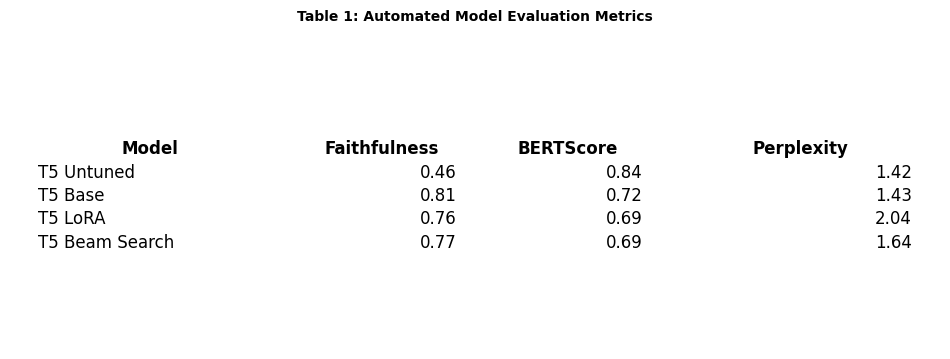

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the file
file_path = "/content/drive/My Drive/automated_metrics_table.csv"
df = pd.read_csv(file_path)

# Round values to 2 decimal places and format Perplexity column
df = df.round(2)
df['Perplexity'] = df['Perplexity'].apply(lambda x: f"{x:,.2f}")

# Create a Figure for the Table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

# Create Table
tbl = plt.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.3, 0.2, 0.2, 0.3]
)

# Adjust Table Styles
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.4)

# Align Columns
for key, cell in tbl.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', ha='center')  # Bold and center-align headers
    elif key[1] == 0:  # First column (Model)
        cell.set_text_props(ha='left')  # Left-align Model column
    else:
        cell.set_text_props(ha='right')  # Right-align numerical values
    cell.set_linewidth(0)  # Remove borders

# Add Title with Spacing
plt.title("Table 1: Automated Model Evaluation Metrics", fontsize=10, weight='bold', pad=15)

# Save as High-Resolution Files
plt.savefig("/content/drive/My Drive/publishable_table_minimalist.png", dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.savefig("/content/drive/My Drive/publishable_table_minimalist.svg", format='svg', bbox_inches='tight', pad_inches=0.3)

plt.show()


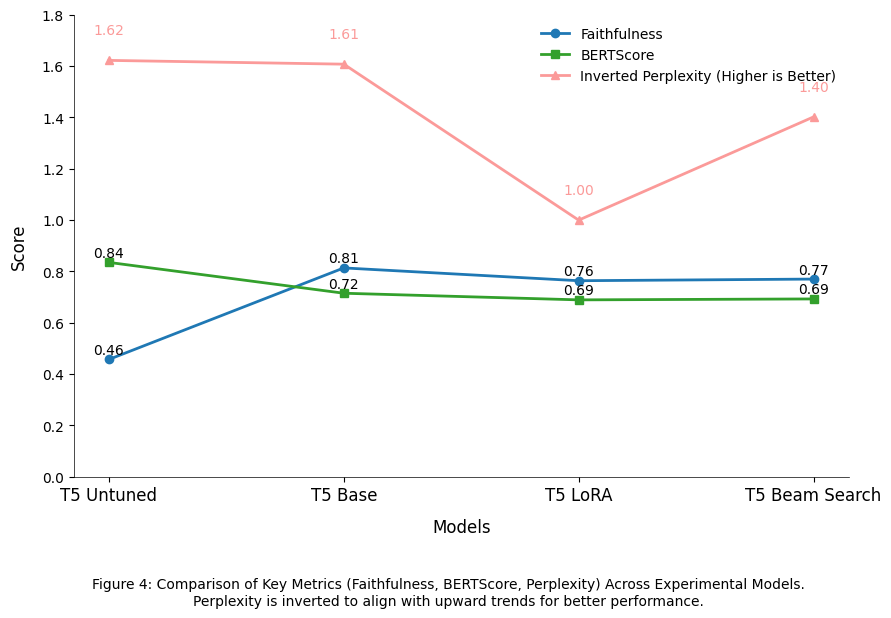

In [ ]:
#trend fo the table data for the experimental models

import matplotlib.pyplot as plt
import numpy as np


# Reordered Data
models = ["T5 Untuned", "T5 Base", "T5 LoRA", "T5 Beam Search"]
faithfulness = [0.457380, 0.813832, 0.763940, 0.770380]
bertscore = [0.835291, 0.715196, 0.689338, 0.692992]
perplexity = [1.416562, 1.431292, 2.038954, 1.636828]

# Calculate Inverted Perplexity
baseline = max(perplexity) + 1  # Add an offset for clarity
inverted_perplexity = [baseline - p for p in perplexity]

# X-axis positions
x = np.arange(len(models))

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each metric
ax.plot(x, faithfulness, marker="o", label="Faithfulness", color="#1F78B4", linewidth=2, markersize=6)
ax.plot(x, bertscore, marker="s", label="BERTScore", color="#33A02C", linewidth=2, markersize=6)
ax.plot(x, inverted_perplexity, marker="^", label="Inverted Perplexity (Higher is Better)", color="#FB9A99", linewidth=2, markersize=6)



# Add labels, legend, and ticks
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylabel("Score", fontsize=12, labelpad=10)
ax.set_xlabel("Models", fontsize=12, labelpad=10)
#ax.set_title("Key Metrics Across Experimental Models", fontsize=14, pad=15)
ax.legend( loc="upper right", fontsize=10, frameon=False)

# Set y-axis limits
ax.set_ylim(0, 1.8)

# Minimalist style
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.set_facecolor("white")

# Add data labels to points
for i in range(len(models)):
    ax.text(x[i], faithfulness[i] + 0.02, f"{faithfulness[i]:.2f}", ha="center", fontsize=10)
    ax.text(x[i], bertscore[i] + 0.02, f"{bertscore[i]:.2f}", ha="center", fontsize=10)
    ax.text(x[i], inverted_perplexity[i] + 0.1, f"{inverted_perplexity[i]:.2f}", ha="center", fontsize=10, color="#FB9A99")

# Add caption below the chart
fig.text(
    0.5,
    -0.1,
    "Figure 4: Comparison of Key Metrics (Faithfulness, BERTScore, Perplexity) Across Experimental Models.\nPerplexity is inverted to align with upward trends for better performance.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
)

# Save as High-Resolution File
plt.savefig(
    "/content/drive/My Drive/automated_evaluation_metrics_graph.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.3,
)

# Display the chart
plt.show()


##Graphs for data set validation by Coach

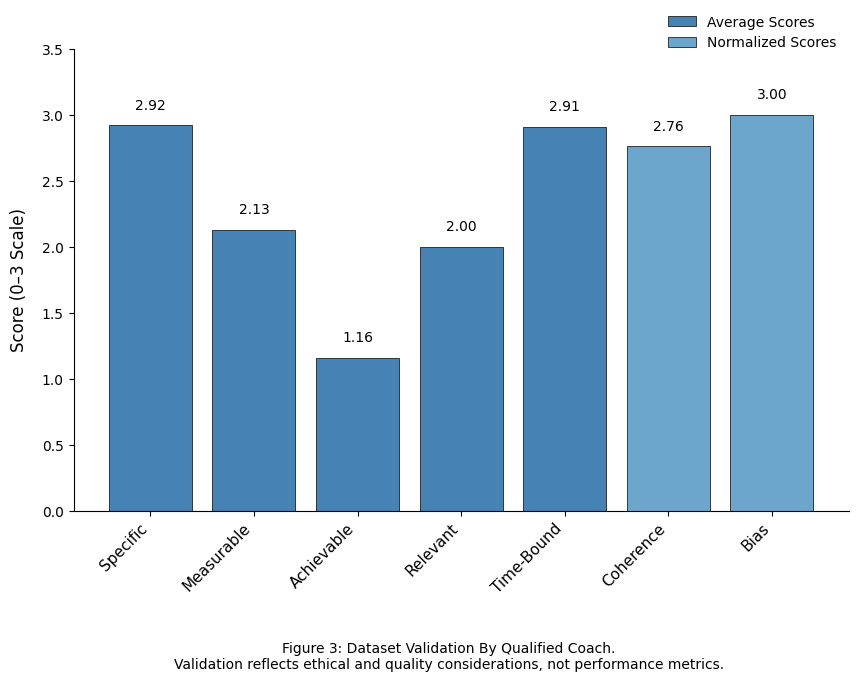

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data is fixed and wont move source excel
criteria = ["Specific", "Measurable", "Achievable", "Relevant", "Time-Bound", "Coherence", "Bias"]
scores = [2.92, 2.13, 1.16, 2.00, 2.91, 2.76, 3.00]  # SMART criteria and normalized Coherence/Bias

# X-axis Positions
x_pos = np.arange(len(criteria))

# Create Figure and Axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and hatches for bars
bar_colors = ["#4682B4"] * 5 + ["#6CA6CD", "#6CA6CD"]

# Plot the Bar Chart
bars = ax.bar(
    x_pos,
    scores,
    color=bar_colors,
    edgecolor="black",
    linewidth=0.5,

)

# Set Labels and Title
ax.set_ylim(0, 3.5)
ax.set_ylabel("Score (0–3 Scale)", fontsize=12, labelpad=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(criteria, rotation=45, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add Bar Annotations (Scores)
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{score:.2f}", ha='center', va='bottom', fontsize=10)

# Add Legend
legend_labels = [
    "Average Scores",
    "Normalized Scores"
]
legend_colors = [bars[0], bars[5]]
ax.legend(legend_colors, legend_labels, loc='upper right',bbox_to_anchor=(1, 1.1), fontsize=10, frameon=False)



# Add Figure Caption
fig.text(0.5, -0.15, "Figure 3: Dataset Validation By Qualified Coach.\nValidation reflects ethical and quality considerations, not performance metrics.", wrap=True, horizontalalignment='center', fontsize=10)
# Save as High-Resolution
plt.savefig("/content/drive/My Drive/human_validation_dataset.png", dpi=300, bbox_inches='tight', pad_inches=0.3)
# Display Chart
plt.show()


Human evalutaion graph for the 4 experiments, measruing Faithfulness, SMART
 Adherence ad Coherence

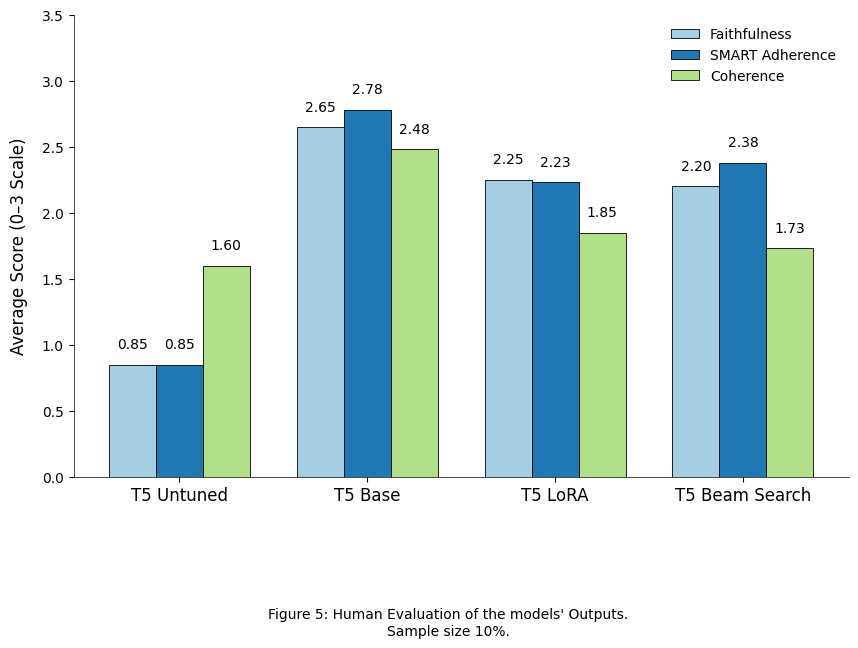

In [ ]:
#Human evaluation

import matplotlib.pyplot as plt
import numpy as np

# Data for the models and criteria
models = ["T5 Untuned","T5 Base", "T5 LoRA", "T5 Beam Search"]
criteria = ["Faithfulness", "SMART Adherence", "Coherence"]
data = [
    [0.85, 0.85, 1.60],   # T5 Untuned
    [2.65, 2.78, 2.48],  # T5 Base
    [2.25, 2.23, 1.85],  # T5 LoRA
    [2.20, 2.38, 1.73],  # T5 Beam Search

]

# Convert data to NumPy array for easier manipulation
data = np.array(data)

# X-axis positions
x = np.arange(len(models))
width = 0.25  # Bar width

# Colors for muted styling
colors = ["#A6CEE3", "#1F78B4", "#B2DF8A"]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each criterion
for i, criterion in enumerate(criteria):
    ax.bar(x + i * width, data[:, i], width, label=criterion, color=colors[i], edgecolor="black", linewidth=0.6)

# Add labels, legend, and ticks
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=0, fontsize=12)
ax.set_ylim(0, 3.5)
ax.set_ylabel("Average Score (0–3 Scale)", fontsize=12, labelpad=10)
ax.legend(loc="upper right", fontsize=10, frameon=False)

# Add white space and a clear background
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.set_facecolor("white")

# Add data labels to bars
for i in range(len(models)):
    for j in range(len(criteria)):
        ax.text(
            x[i] + j * width,
            data[i, j] + 0.1,
            f"{data[i, j]:.2f}",
            ha="center",
            va="bottom",
            fontsize=10
        )

# Add caption below the chart
fig.text(0.5, -0.15, "Figure 5: Human Evaluation of the models' Outputs.\nSample size 10%.", wrap=True, horizontalalignment='center', fontsize=10)

# Save the chart as PNG
plt.savefig("/content/drive/My Drive/Human_Evaluation_Scores.png", dpi=300, bbox_inches='tight', pad_inches=0.5)

# Display the chart
plt.show()



Faithfulness comparsions for all the models, as it is a key metrics in detrmining the quality and usefulness of SMART goal generation.The second grpah is to show alignment and work out the coeffeicent

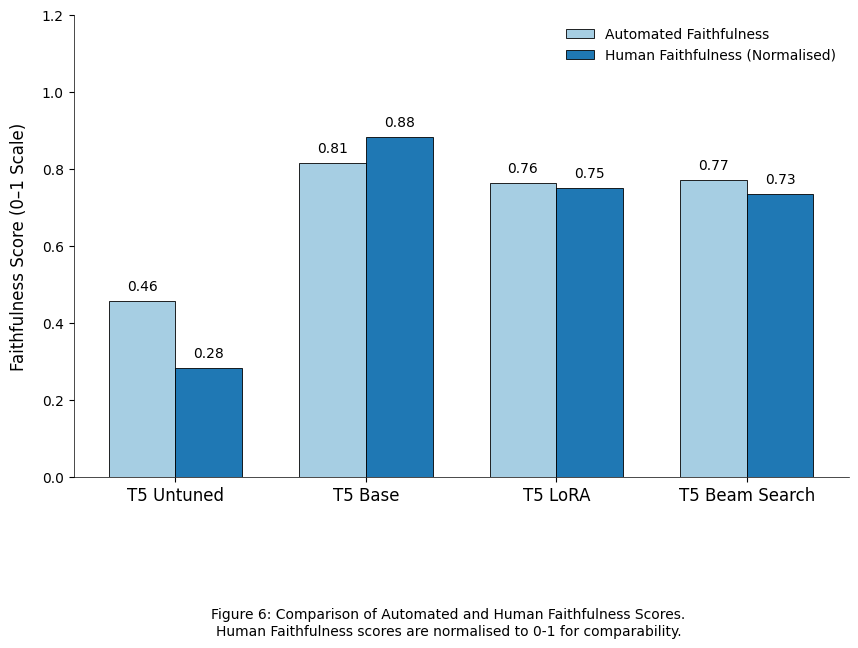

In [ ]:
#Faithfulness comparions for experiments

import matplotlib.pyplot as plt
import numpy as np


# Data for Faithfulness Scores
models = ["T5 Untuned","T5 Base", "T5 LoRA", "T5 Beam Search"]
automated_faithfulness = [0.457380, 0.813832, 0.763940, 0.770380 ]
human_faithfulness = [0.85,2.65, 2.25, 2.20]  # Normalised to 0-3 scale

# Normalize human Faithfulness to match automated scale (0-1)
human_faithfulness_normalised = [score / 3 for score in human_faithfulness]

# X-axis positions
x = np.arange(len(models))
width = 0.35  # Bar width

# Colors for styling
colors = ["#A6CEE3", "#1F78B4"]  s

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for automated and human Faithfulness
ax.bar(x - width / 2, automated_faithfulness, width, label="Automated Faithfulness", color=colors[0], edgecolor="black", linewidth=0.6)
ax.bar(x + width / 2, human_faithfulness_normalised, width, label="Human Faithfulness (Normalised)", color=colors[1], edgecolor="black", linewidth=0.6)

# Add labels, legend, and ticks
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0, fontsize=12)
ax.set_ylim(0, 1.2)
ax.set_ylabel("Faithfulness Score (0–1 Scale)", fontsize=12, labelpad=10)
ax.legend(loc="upper right", fontsize=10, frameon=False)

# Add white space and a clean background
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.set_facecolor("white")

# Add data labels to bars
for i in range(len(models)):
    ax.text(
        x[i] - width / 2,
        automated_faithfulness[i] + 0.02,
        f"{automated_faithfulness[i]:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
    ax.text(
        x[i] + width / 2,
        human_faithfulness_normalised[i] + 0.02,
        f"{human_faithfulness_normalised[i]:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Add caption below the chart
fig.text(0.5, -0.15, "Figure 6: Comparison of Automated and Human Faithfulness Scores.\nHuman Faithfulness scores are normalised to 0-1 for comparability.", wrap=True, horizontalalignment='center', fontsize=10)


# Save as High-Resolution File
plt.savefig("/content/drive/My Drive/Faithfulness_Comparison.png", dpi=300, bbox_inches='tight', pad_inches=0.3)


# Display the chart
plt.show()




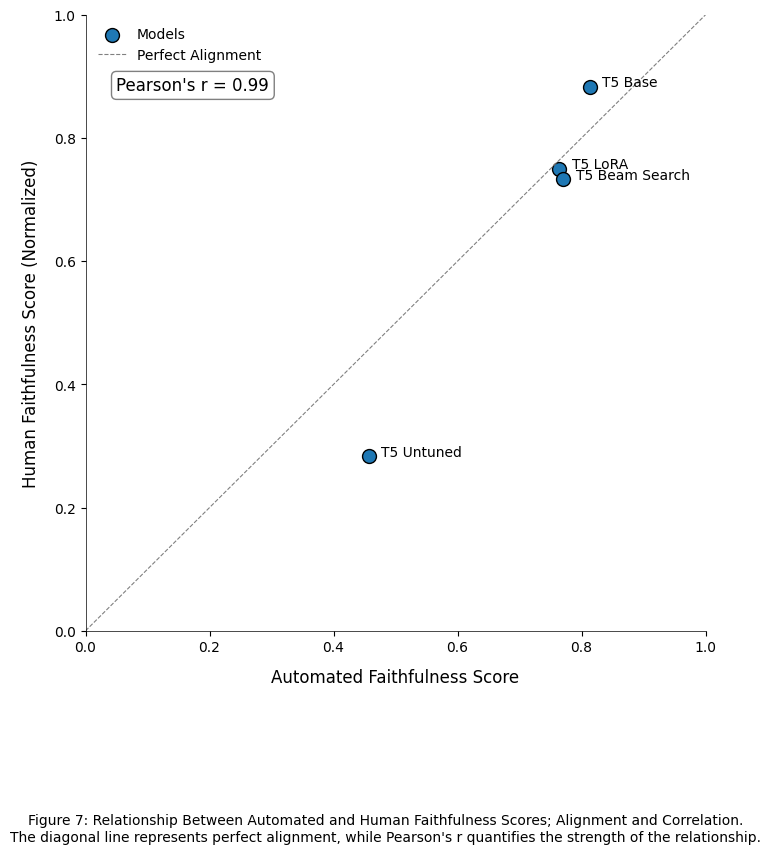

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Data for Faithfulness Scores
models = ["T5 Untuned", "T5 Base", "T5 LoRA", "T5 Beam Search"]
automated_faithfulness = [0.457380, 0.813832, 0.763940, 0.770380]
human_faithfulness = [0.85, 2.65, 2.25, 2.20]  # Normalized to 0-3 scale

# Normalize human Faithfulness to match automated scale (0-1)
human_faithfulness_normalized = [score / 3 for score in human_faithfulness]

# Calculate Pearson correlation coefficient (r)
correlation, _ = pearsonr(automated_faithfulness, human_faithfulness_normalized)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of faithfulness scores
scatter = ax.scatter(
    automated_faithfulness,
    human_faithfulness_normalized,
    color="#1F78B4",
    edgecolor="black",
    s=100,
    label="Models"
)

# Annotate points with model names
for i, model in enumerate(models):
    ax.annotate(model, (automated_faithfulness[i] + 0.02, human_faithfulness_normalized[i]), fontsize=10)

# Add diagonal line for perfect alignment
line, = ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=0.8, label="Perfect Alignment")

# Display correlation coefficient on the plot
ax.text(0.05, 0.9, f"Pearson's r = {correlation:.2f}", fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# Set axis labels and limits
ax.set_xlabel("Automated Faithfulness Score", fontsize=12, labelpad=10)
ax.set_ylabel("Human Faithfulness Score (Normalized)", fontsize=12, labelpad=10)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


ax.legend(
    handles=[scatter, line],
    labels=["Models", "Perfect Alignment"],
    loc="upper left",
    fontsize=10,
    frameon=False
)


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.set_facecolor("white")

# Add caption below the chart
fig.text(
    0.5,
    -0.15,
    "Figure 7: Relationship Between Automated and Human Faithfulness Scores; Alignment and Correlation.\nThe diagonal line represents perfect alignment, while Pearson's r quantifies the strength of the relationship.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10
)

# Save as high-resolution file
plt.savefig("/content/drive/My Drive/Combined_Alignment_Correlation.png", dpi=300, bbox_inches="tight", pad_inches=0.3)

# Display the chart
plt.show()



Holistic view of all the experiments

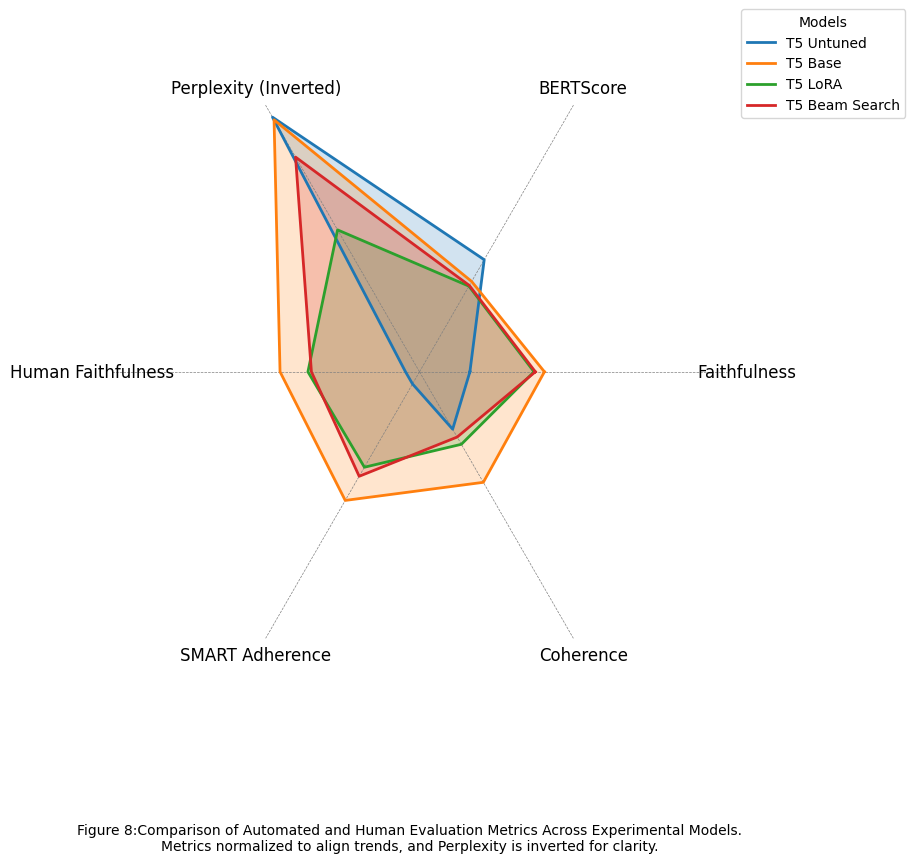

In [ ]:
#all the metrics togther for the experiments

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["T5 Untuned", "T5 Base", "T5 LoRA", "T5 Beam Search"]
automated_data = [
    [0.457380, 0.835291, 1.416562],  # T5 Untuned
    [0.813832, 0.715196, 1.431292],  # T5 Base
    [0.763940, 0.689338, 2.038954],  # T5 LoRA
    [0.770380, 0.692992, 1.636828]   # T5 Beam Search
]
human_data = [
    [0.85 / 3, 0.85 / 3, 1.60 / 3],  # T5 Untuned
    [2.65 / 3, 2.78 / 3, 2.48 / 3],  # T5 Base
    [2.25 / 3, 2.23 / 3, 1.85 / 3],  # T5 LoRA
    [2.20 / 3, 2.38 / 3, 1.73 / 3]   # T5 Beam Search
]

# Invert Perplexity (higher is better)
max_perplexity = max([row[2] for row in automated_data]) + 1
for row in automated_data:
    row[2] = max_perplexity - row[2]

# Combine Automated and Human Data
metrics = ["Faithfulness", "BERTScore", "Perplexity (Inverted)", "Human Faithfulness", "SMART Adherence", "Coherence"]
data_combined = []
for i in range(len(models)):
    data_combined.append(automated_data[i] + human_data[i])

# Set up Radar Chart
num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
colors_automated = ["#A6CEE3", "#1F78B4", "#B2DF8A"]  # Automated (Faithfulness, BERTScore, Perplexity)
colors_human = ["#A6CEE3", "#1F78B4", "#B2DF8A"]      # Human (Faithfulness, SMART Adherence, Coherence)

for i, (model, data) in enumerate(zip(models, data_combined)):
    data = data + data[:1]
    ax.plot(angles, data, linewidth=2, linestyle="solid", label=model)
    ax.fill(angles, data, alpha=0.2)

# Add labels for each metric
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)

# Minimalist Style
ax.spines["polar"].set_visible(False)
ax.grid(color="gray", linestyle="--", linewidth=0.5)
ax.set_facecolor("white")

# Add legend and caption
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10, title="Models")
fig.text(
    0.5,
    -0.1,
    "Figure 8:Comparison of Automated and Human Evaluation Metrics Across Experimental Models.\nMetrics normalized to align trends, and Perplexity is inverted for clarity.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
)

# Save as High-Resolution File
plt.savefig(
    "/content/drive/My Drive/comprehensive_metrics_radar_chart.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.3,
)

# Display the chart
plt.show()


##test data evaluations showing generalistaion

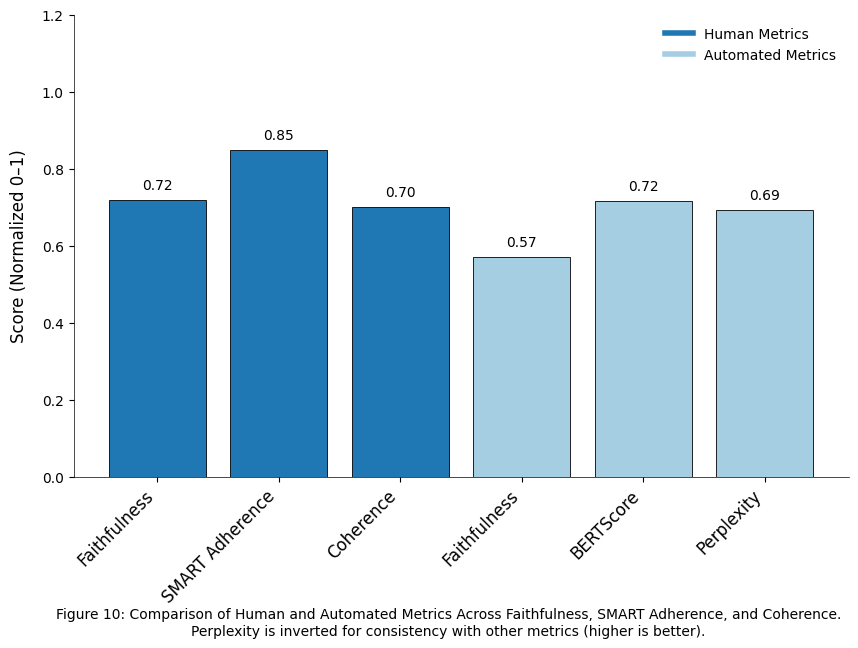

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data for all metrics
metrics = ["Faithfulness", "SMART Adherence", "Coherence", "Faithfulness", "BERTScore", "Perplexity"]
scores = [0.72, 0.85, 0.70, 0.5714, 0.7165, 1/1.4444]  # Normalized/Inverted data

# Colors for styling
human_color = "#1F78B4"
automated_color = "#A6CEE3"
colors = [human_color] * 3 + [automated_color] * 3

# X-axis positions
x_pos = np.arange(len(metrics))

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x_pos, scores, color=colors, edgecolor="black", linewidth=0.6)

# Add labels, ticks, and title
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, rotation=45, ha="right", fontsize=12)
ax.set_ylabel("Score (Normalized 0–1)", fontsize=12, labelpad=10)
ax.set_ylim(0, 1.2)

# Minimalist styling
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.set_facecolor("white")

ax.grid(False)

# Add data labels
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{score:.2f}",
            ha="center", va="bottom", fontsize=10)

# Add a legend for Human and Automated Metrics
ax.legend(handles=[
    plt.Line2D([0], [0], color="#1F78B4", lw=4, label="Human Metrics"),
    plt.Line2D([0], [0], color="#A6CEE3", lw=4, label="Automated Metrics")
], loc="upper right", fontsize=10, frameon=False)

# Add caption below the chart
fig.text(0.5, -0.15, "Figure 10: Comparison of Human and Automated Metrics Across Faithfulness, SMART Adherence, and Coherence.\nPerplexity is inverted for consistency with other metrics (higher is better).",
         wrap=True, horizontalalignment="center", fontsize=10)

# Save the chart
plt.savefig("/content/drive/My Drive/Test_data_Human_vs_Automated_Metrics.png", dpi=300, bbox_inches="tight", pad_inches=0.3)

# Show the chart
plt.show()
